In [7]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

import scprep
import phate
import pickle
import graphtools
import scipy

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
#from MSS_functions import *
from pcnn import DATA_DIR

In [8]:
import scprep
## files avail to anyone with link 

scprep.io.download.download_google_drive("16nbyiNv-AX9zVBHC1XUfN0LWGeA1Sf0k", os.path.join(DATA_DIR,"scaled_cell_intensities.csv"))
data = pd.read_csv(os.path.join(DATA_DIR,"scaled_cell_intensities.csv"), index_col = 0).drop(columns = ['area', 'x_centroid', 'y_centroid', 'Cell Instance'])
data.index = [data.index[i].split("_")[1] for i, lab in enumerate(data.index)]

### log transform and normalize
data_norm = scprep.transform.log(data) #default base=10
data_norm = scprep.normalize.library_size_normalize(data_norm, rescale = 1000)

In [9]:
#unique patient and cell identifiers
grouped_data = data_norm.groupby(data_norm.index).cumcount() + 1
patient_data = {p: group for p, group in data_norm.groupby(data_norm.index)}
metadata = pd.DataFrame()
metadata["patient_id"] = data_norm.index
metadata.index = [f"{p}_{i}" for p, i in zip(metadata["patient_id"], grouped_data)]
for p in patient_data:
    patient_data[p].index = [f"{p}_{i}" for p, i in zip(patient_data[p].index, grouped_data)]

##store UMI in metadata
metadata.index = metadata.index + "_" + grouped_data.astype(str)

In [10]:
patient_data.keys()


dict_keys(['R10C2', 'R10C3', 'R10C4', 'R10C5', 'R11C1', 'R11C3', 'R11C4', 'R11C5', 'R12C1', 'R12C2', 'R12C3', 'R12C4', 'R12C5', 'R1C2', 'R1C3', 'R1C4', 'R1C5', 'R2C2', 'R2C3', 'R2C4', 'R2C5', 'R3C1', 'R3C2', 'R3C3', 'R3C4', 'R3C5', 'R4C1', 'R4C2', 'R4C3', 'R4C4', 'R4C5', 'R5C1', 'R5C3', 'R5C4', 'R5C5', 'R6C1', 'R6C2', 'R6C3', 'R6C4', 'R6C5', 'R7C1', 'R7C2', 'R7C3', 'R7C4', 'R7C5', 'R8C1', 'R8C2', 'R8C3', 'R8C4', 'R8C5', 'R9C1', 'R9C2', 'R9C3', 'R9C4'])

In [6]:
data_norm.columns

Index(['beta-tubulin', 'CD11b', 'CD11c', 'CD14', 'CD163', 'CD20', 'CD3',
       'CD31', 'CD4', 'CD45', 'CD45RO', 'CD56', 'CD68', 'CD8', 'dsDNA',
       'FOXP3', 'Granzyme B', 'HLA class 1 A, B, and C, Na-K-ATPase',
       'HLA DPDQDR', 'IDO-1', 'Ki-67', 'LAG3', 'PD-1', 'PD-L1', 'Podoplanin',
       'SMA', 'SOX10', 'TIM-3', 'Vimentin'],
      dtype='object')

### Code for subsampling point clouds

In [6]:
# Subsample

n_points = 400
n_samples = 10
subsampled_pcs = []
subsampled_patient_ids = []
labels = []

for pat_id in patient_data.keys():
    len_pat = len(patient_data[pat_id])
    for n in range(n_samples):
        idx = np.random.choice(np.arange(len_pat),size=n_points, replace = False)
        subsampled_pcs.append(patient_data[pat_id].iloc[idx].values)
        subsampled_patient_ids.append(pat_id)
        
        labels.append(np.random.randint(2))

labels = np.array(labels)

import pickle

with open(os.path.join(DATA_DIR,'melanoma','pc.pkl'), 'wb') as handle:
    pickle.dump(subsampled_pcs, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(DATA_DIR,'melanoma','patient_list.pkl'), 'wb') as handle:
    pickle.dump(subsampled_patient_ids, handle, protocol=pickle.HIGHEST_PROTOCOL)

np.save(os.path.join(DATA_DIR,'melanoma','labels.npy'), labels)


In [32]:
subsampled_pcs[0].shape

(400, 29)

### Number of cells per patient

489


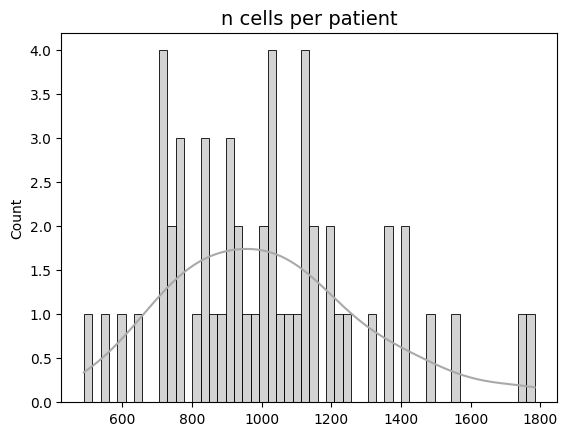

In [11]:
pc = np.array([patient_data[p].shape[0] for i, p in enumerate(list(patient_data.keys()))])
print(np.min(pc))
sns.histplot(pc, bins = 54, color = 'darkgray', kde= True)
plt.title('n cells per patient', size = 14)
plt.show()

In [20]:
#load clinical data
scprep.io.download.download_google_drive("17CHXcF0FKRt-QkEaw84lBvTZ5MqnDytT", os.path.join(DATA_DIR,"melanoma_clinical_info_MIBI.csv"))
clinical_data = pd.read_csv(os.path.join(DATA_DIR,"melanoma_clinical_info_MIBI.csv"), index_col = 0)

# patient_ID to match data labels
c_id = list(clinical_data['376_1_col']) #column on MIBI plate
r_id = list(clinical_data['376_1_row']) #row on MIBI plate
clinical_data["Patient_ID"] = np.array(["R"+str(c_id[i])+'C'+str(r_id[i]) for i, idx in enumerate(clinical_data.index) ])\

#filter by patient IDs with samples present
res = [i for i, val in enumerate(clinical_data["Patient_ID"]) if val in data_norm.index]
clinical_data = clinical_data.iloc[res].set_index("Patient_ID")

###################################################
###################################################

clinical_features = np.array(["SEX", "RACE", "AGE_AT_DX", "DX_STAGE", "Prior_Checkpoint_Blockade", "TREATMENT"])
clinical= pd.DataFrame(index = clinical_data.index)
#sex
cd = pd.DataFrame(clinical_data[clinical_features[0]])
cd = cd.replace({clinical_features[0]: {"F":1, "M": 0}})
clinical = clinical.join(cd, how= 'inner')
#age
cd = pd.DataFrame(clinical_data[clinical_features[2]])
cd = cd.replace({clinical_features[1]: {"BLACK":1, "HISPANIC": 0, "WHITE": 2}})
clinical = clinical.join(cd, how= 'inner')
#stage
cd = pd.DataFrame(clinical_data[clinical_features[3]])
cd = cd.replace({clinical_features[3]: {"I":0, "IB":0, "IIA": 1, "IIB":1, "IIC":1, "III": 2, "IIIA":2, "IIIB":2, "IIIC":2,
                                                   "IV": 3, "IVA":3, "IVB (H&N)": 3, "UNKNOWN": 4}})
clinical = clinical.join(cd, how= 'inner')

#prior blockade
cd = pd.DataFrame(clinical_data[clinical_features[4]])
cd = cd.replace({clinical_features[4]: {"NO":0, "YES": 1}})
clinical = clinical.join(cd, how= 'inner')
#treatment type
cd = pd.DataFrame(clinical_data[clinical_features[5]])
cd = cd.replace({clinical_features[5]: {"IPI+NIVO":0, "NIVO": 1, "PEMBRO":2}})
clinical = clinical.join(cd, how= 'inner')


In [18]:
clinical

,SEX,AGE_AT_DX,DX_STAGE,Prior_Checkpoint_Blockade,TREATMENT
Patient_ID,,,,,
R3C2,0,88,1,0,2
R4C1,1,62,3,0,0
R4C3,1,56,3,0,0
R5C1,0,74,2,0,0
R5C5,0,57,2,0,0
R1C5,1,75,2,0,2
R2C4,0,82,2,0,1
R2C5,0,50,0,1,1
R3C4,1,71,3,1,0


In [21]:
clinical_data

,SPID,Core Type,block,SEX,RACE,AGE_AT_DX,DX_STAGE,BEST_RESPONSE_BY_SCAN,RESPONSE,PFS_BY_SCAN,PROG_STATUS_BY_SCAN,OS_FROM_START_OF_ITX,VITAL,SPEC_CATEGORY,Prior_Checkpoint_Blockade,TREATMENT,MUTATION,376_1_row,376_1_col,376_1_13_CMTM6___CD68___PD_L1_SxM_Spot__
Patient_ID,,,,,,,,,,,,,,,,,,,,
R2C3,32151,Tumor,6-Jan,M,WHITE,88,IIB,PD,NO,72,1,476,0,CUTANEOUS PRIMA,NO,PEMBRO,NRAS Q61L,3,2,63
R9C3,32158,Tumor,4-Jan,F,WHITE,61,IIIB,PD,NO,57,1,261,1,CUTANEOUS PRIMA,NO,IPI+NIVO,NRAS,3,9,22
R7C3,32156,Tumor,1-Feb,M,WHITE,88,IIIB,PD,NO,67,1,107,1,MET,NO,NIVO,NONE,3,7,34
R1C4,32162,Tumor,2-May,F,WHITE,62,IV,PD,NO,75,1,432,1,MUCOSAL PRIMARY,NO,IPI+NIVO,NRAS Q61K,4,1,69
R3C4,32163,Tumor,3-Jan,F,WHITE,56,IVA,PD,NO,85,1,377,1,MET,NO,IPI+NIVO,NONE,4,3,57
R8C4,32167,Tumor,7-May,M,HISPANIC,59,IIIC,PD,NO,36,1,238,1,NODE,NO,IPI+NIVO,BRAF V600K,4,8,28
R1C5,32172,Tumor,1-Jan,M,WHITE,74,IIIB,PD,NO,81,1,446,1,MET,NO,IPI+NIVO,NONE,5,1,68
R5C5,32176,Tumor,3-Jan,M,WHITE,57,IIIC,PD,NO,66,1,279,1,MET,NO,IPI+NIVO,NONE,5,5,44
R6C5,32177,Tumor,15-Jan,M,WHITE,60,IIIC,PD,NO,66,1,604,1,MET,NO,IPI+NIVO,NONE,5,6,41


In [15]:
patient_data.keys()

dict_keys(['R10C2', 'R10C3', 'R10C4', 'R10C5', 'R11C1', 'R11C3', 'R11C4', 'R11C5', 'R12C1', 'R12C2', 'R12C3', 'R12C4', 'R12C5', 'R1C2', 'R1C3', 'R1C4', 'R1C5', 'R2C2', 'R2C3', 'R2C4', 'R2C5', 'R3C1', 'R3C2', 'R3C3', 'R3C4', 'R3C5', 'R4C1', 'R4C2', 'R4C3', 'R4C4', 'R4C5', 'R5C1', 'R5C3', 'R5C4', 'R5C5', 'R6C1', 'R6C2', 'R6C3', 'R6C4', 'R6C5', 'R7C1', 'R7C2', 'R7C3', 'R7C4', 'R7C5', 'R8C1', 'R8C2', 'R8C3', 'R8C4', 'R8C5', 'R9C1', 'R9C2', 'R9C3', 'R9C4'])

### Phate and clusters

In [9]:
'''
##################################### spectral cluster with PHATE #####################################

PHATE: landmark graph
- apply PCA to diffusion operator
- k-means cluster PCs

phate_op.diff_potential = PMN matrix, (i,j) = transition prob of i-th cell to j-th landmark
'''

##PHATE embedding of all data
phate_op = phate.PHATE(n_components=3, knn=5, random_state = 1)
data_phate = phate_op.fit(data)


##number of cluster centroids for dirac signal placement
k=10

##PHATE embedding with 
phate_clust_op = phate.PHATE(n_components=2, knn=5, n_landmark= k, random_state = 1)
clust_phate = phate_clust_op.fit(data)
#PMN = phate_clust_op.diff_potential #using the k-landmarks landmark graph

Running PHATE on 54989 observations and 29 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 99.45 seconds.
  Calculating affinities...
  Calculated affinities in 0.24 seconds.
Calculated graph and diffusion operator in 99.73 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 4.16 seconds.
  Calculating KMeans...
  Calculated KMeans in 2.03 seconds.
Calculated landmark operator in 7.60 seconds.
Running PHATE on 54989 observations and 29 variables.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 101.42 seconds.
  Calculating affinities...
  Calculated affinities in 0.20 seconds.
Calculated graph and diffusion operator in 101.66 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 4.19 seconds.
  Calculating KMeans...
  Calculated KMeans in 0.27 seconds.
Calculated landmark operator in 4.48 seconds.


In [16]:
#ignore warnings
spectral_clusters= phate_clust_op.graph.clusters
spectral_centroids = data.groupby(phate_clust_op.graph.clusters).mean()
spectral_centroid_embed = phate_op.transform(spectral_centroids)

Calculating optimal t...


/gpfs/gibbs/project/krishnaswamy_smita/ed667/conda_envs/pcnn/lib/python3.9/site-packages/phate/phate.py:884: RuntimeWarning: Pre-fit PHATE should not be used to transform a new data matrix. Please fit PHATE to the new data by running 'fit' with the new data.
  warnings.warn(


  Automatically selected t = 33
Calculated optimal t in 3.44 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.45 seconds.
Calculating metric MDS...


/gpfs/gibbs/project/krishnaswamy_smita/ed667/conda_envs/pcnn/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Calculated metric MDS in 59.76 seconds.
Calculating KNN search...
Calculated KNN search in 0.06 seconds.
Calculating affinities...


/gpfs/gibbs/project/krishnaswamy_smita/ed667/conda_envs/pcnn/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


In [19]:
spectral_centroid_embed

array([[ 0.00540055, -0.00349877, -0.00110755],
       [-0.0199815 , -0.00579357, -0.00018458],
       [ 0.00273996,  0.00614253, -0.00635014],
       [-0.01543048, -0.00144494,  0.008916  ],
       [-0.01065216, -0.00293478,  0.00306355],
       [ 0.02877145,  0.01128283, -0.01074145],
       [-0.01481629,  0.0009898 , -0.00191862],
       [ 0.00508226, -0.00529053, -0.00211654],
       [-0.00025068, -0.00603917, -0.01053388],
       [-0.01492484, -0.00035246, -0.00280105]])

In [18]:
spectral_centroids

,beta-tubulin,CD11b,CD11c,CD14,CD163,CD20,CD3,CD31,CD4,CD45,...,IDO-1,Ki-67,LAG3,PD-1,PD-L1,Podoplanin,SMA,SOX10,TIM-3,Vimentin
0,65.957357,9.362114,8.009458,17.754904,12.435918,0.273783,5.541239,5.772823,6.570199,10.207844,...,3.134411,14.113985,4.065033,5.001706,4.051174,0.976265,8.898435,18.829478,8.133567,51.166689
1,72.891742,1.480094,1.744988,2.093712,1.296066,0.232911,1.033930,0.642507,3.991073,4.610678,...,0.449613,9.056232,2.295815,3.656690,1.810878,0.216158,2.117313,37.641339,2.288101,58.462584
2,57.719343,6.180323,4.746608,12.244785,10.233582,8.481122,5.550098,2.090047,7.231179,13.214388,...,2.890959,10.386687,1.658438,4.241890,1.206799,2.144948,8.105504,7.212787,4.617796,35.323347
3,71.072798,1.133580,1.891356,2.595905,1.268223,0.359817,1.203549,0.586355,3.084736,4.319712,...,1.416347,41.553037,3.135904,4.452334,2.964042,0.155638,2.902455,32.078750,1.873144,52.904309
4,72.995545,5.542041,1.620956,10.038271,6.955581,0.397319,3.286614,1.828802,4.962500,6.964733,...,2.107260,9.108967,4.078988,3.069645,4.249398,1.029959,2.407943,32.105049,5.316696,58.347876
5,61.521606,25.353394,16.760136,42.261808,33.226855,0.039678,2.795776,9.404673,10.873714,14.355800,...,9.581234,1.953722,1.651220,1.819693,3.812329,3.538124,16.485085,1.004123,14.540805,49.658431
6,60.310985,2.728885,3.065884,3.979606,3.182262,0.414003,0.922934,1.031784,1.883199,5.202095,...,1.142238,10.121365,1.540083,2.177433,1.746723,0.426813,5.629191,18.156607,2.266995,49.112794
7,67.369853,8.687686,6.102185,20.131233,15.513381,0.198458,1.742413,1.807765,4.275839,6.561033,...,1.693418,10.512435,2.517453,2.490473,2.748882,0.389459,3.003528,31.956106,5.409716,50.892798
8,63.264625,0.160017,2.231014,1.995303,0.361036,0.121089,0.402127,0.087166,1.563190,0.801514,...,0.056540,5.219569,0.569863,2.863166,0.418473,1.669936,1.313499,26.902438,0.777365,32.327756
9,55.591288,3.323382,1.464415,5.248292,4.370298,0.192373,1.347136,1.553387,2.740642,3.064592,...,1.626348,8.994182,1.627821,1.588196,1.930470,0.669620,2.359962,31.943084,3.451664,40.253491
